In [1]:
import random
import time
import os

import cv2
import numpy as np

import torch
import torchvision
from PIL import Image, ImageFilter
from IPython import display

import torchvision.models
from torchvision.transforms import transforms

from tqdm.notebook import tqdm

import matplotlib.pyplot as plt

import imagehash

In [5]:
def __group_similar_images(ordered_dir, cutoff):
    image_locs = [f"{ordered_dir}/{file_name}" for file_name in os.listdir(ordered_dir) if file_name.endswith(".jpg")]
    groups = [[image_locs[0]]]
    last_hash = imagehash.average_hash(Image.open(image_locs[0]))
    
    for image_loc in tqdm(image_locs):
        img_hash = imagehash.average_hash(Image.open(image_loc))
        diff = img_hash - last_hash
        
        if diff <= cutoff:
            groups[-1].append(image_loc)
        else:
            groups.append([image_loc])
            
        last_hash = img_hash
    
    return groups

In [26]:
def group_similar_images(ordered_dir, cutoff):
    image_locs = [f"{ordered_dir}/{file_name}" for file_name in os.listdir(ordered_dir) if file_name.endswith(".jpg")]
    groups = [[image_locs[0]]]
    
    for image_loc in tqdm(image_locs):
        img_hash = imagehash.average_hash(Image.open(image_loc))
        
        closest_group_idx = -1
        closest_group_diff = 65
        
        for offset, group in enumerate(groups[-5:][::-1]):
            group_idx = len(groups) - offset - 1
            last_hash = imagehash.average_hash(Image.open(group[-1]))
            diff = img_hash - last_hash
            
            if diff < closest_group_diff:
                closest_group_idx = group_idx
                closest_group_diff = diff
        
        diff = img_hash - last_hash
        
        if closest_group_diff <= cutoff:
            groups[closest_group_idx].append(image_loc)
        else:
            groups.append([image_loc])
    
    return groups

In [55]:
domain_dir = "pose_classified_movie"
cutoff = 8

input_directories = [
    f"./output/{domain_dir}/Full Body Sitting",
    f"./output/{domain_dir}/Full Body Standing",
    f"./output/{domain_dir}/Half Body",
    f"./output/{domain_dir}/Head Only"
]

output_directory = f"./output/{domain_dir}_combined_triplets_fair"
additional_directory = f"./output/{domain_dir}_recycle_test_fair"
additional_desired_count = 200
output_size = 256
min_triplets_from_clip = 2
max_triplets_from_clip = 5
previous_matching_window = 5

os.makedirs(output_directory, exist_ok=False)
os.makedirs(additional_directory, exist_ok=False)

In [36]:
groups = []

for input_directory in input_directories:
    dir_groups = group_similar_images(input_directory, cutoff)
    print(len(dir_groups))
    groups += dir_groups

  0%|          | 0/21 [00:00<?, ?it/s]

20


  0%|          | 0/509 [00:00<?, ?it/s]

237


  0%|          | 0/1763 [00:00<?, ?it/s]

304


  0%|          | 0/1361 [00:00<?, ?it/s]

378


In [56]:
lengths = {}
min_length = min_triplets_from_clip * 3
excluded_count = 0

for group in groups:
    l = len(group)
    
    if l < min_length:
        excluded_count += l
        continue
    
    if l not in lengths.keys():
        lengths[l] = 0
    
    lengths[l] += 1
    
lengths

{7: 11,
 8: 8,
 6: 17,
 12: 5,
 22: 2,
 13: 2,
 29: 1,
 38: 1,
 28: 1,
 15: 1,
 10: 4,
 9: 14,
 11: 11,
 137: 1,
 14: 2,
 60: 1,
 53: 1,
 24: 4,
 40: 1,
 83: 1,
 20: 2,
 254: 1,
 21: 1,
 163: 1,
 36: 1,
 32: 1,
 49: 1,
 16: 3,
 31: 1,
 18: 2,
 71: 1,
 23: 1,
 33: 1,
 17: 1,
 37: 1,
 26: 1,
 67: 1,
 103: 1}

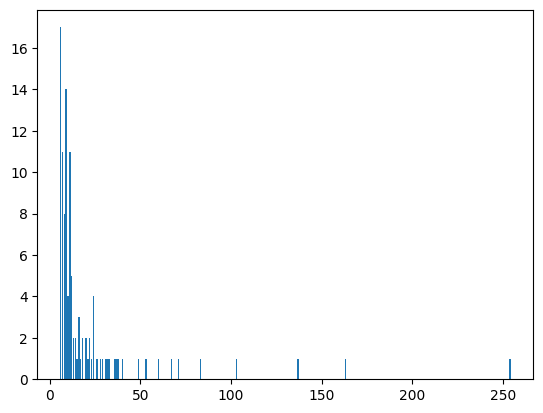

In [57]:
plt.bar(*zip(*lengths.items()))
plt.show()

In [58]:
excluded_count

1304

In [59]:
test_save_prob = additional_desired_count / excluded_count

for group_no, group in enumerate(tqdm(groups)):
    if len(group) < min_length:
        for i in range(len(group)):
            if random.uniform(0, 1) < test_save_prob:
                Image.open(group[i]).save(f"{additional_directory}/{group_no:04d}_{i:04d}.jpg")
        
        continue
        
    triplet_count = len(group) // 3
    selection_count = min(triplet_count, max_triplets_from_clip)
    selected_triplets = random.sample(range(triplet_count), k=selection_count)
    
    for i in selected_triplets:
        triplet_image = Image.new("RGB", (3 * output_size, output_size))
        
        triplet_image.paste(Image.open(group[3 * i]).resize((output_size, output_size)), (0, 0))
        triplet_image.paste(Image.open(group[3 * i + 1]).resize((output_size, output_size)), (output_size, 0))
        triplet_image.paste(Image.open(group[3 * i + 2]).resize((output_size, output_size)), (2 * output_size, 0))
        
        triplet_image.save(f"{output_directory}/{group_no:04d}_{i:04d}.jpg")

  0%|          | 0/939 [00:00<?, ?it/s]